In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import glob

In [ ]:
import os

# dataset 폴더 경로 설정
dataset_folder = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'

# dataset 폴더 아래의 모든 폴더 목록을 얻기
folder_names = [folder for folder in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, folder))]

# 결과 출력
print(folder_names)


['끈적끈적', '나그네', '낙지', '감추다,숨다,은닉', '거짓,허위', '기말시험,기말고사', '가발,덧머리', '껌', '닦다', '뚱뚱이,뚱뚱보,뚱보,뚱땡이']


In [ ]:
import numpy as np
from tqdm import tqdm
actions = folder_names
label_mapping = {action: idx for idx, action in enumerate(actions)}

PATH = '/content/drive/MyDrive/LAB/Sign_Language_Remaster/code/lstm/dataset'

data = []
labels = []

for action in tqdm(actions):
    PATH2 = f'{PATH}/{action}'
    file_path = glob.glob(os.path.join(PATH2, f'seq_*.npy'))[0]
    try:
        loaded_data = np.load(file_path, allow_pickle=True)
        data.append(loaded_data)

        label = np.full((loaded_data.shape[0],), label_mapping[action])
        labels.append(label)
    except FileNotFoundError:
        print(f"File not found for action: {action}")

x_data = np.concatenate(data, axis=0)
labels = np.concatenate(labels, axis=0)


100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


In [ ]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(1173, 10)

In [ ]:
from sklearn.model_selection import train_test_split

# data를 train과 test로 나눔
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# x_train, x_test, y_train, y_test의 크기 확인
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")


x_train shape: (938, 30, 156)
y_train shape: (938, 10)
x_test shape: (235, 30, 156)
y_test shape: (235, 10)


In [ ]:
#model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(32, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                24192     
                                                                 
 dense (Dense)               (None, 10)                330       
                                                                 
Total params: 24522 (95.79 KB)
Trainable params: 24522 (95.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# model 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, activation='tanh', input_shape=x_train.shape[1:3]),
    Dense(32, activation='tanh'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                56576     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 58788 (229.64 KB)
Trainable params: 58788 (229.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    shuffle = False,
    # callbacks=[
    #     ModelCheckpoint('models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
    #     ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    # ]
)

Epoch 1/100
30/30 [==============================] - 4s 41ms/step - loss: 2.0262 - acc: 0.3497 - val_loss: 1.7219 - val_acc: 0.5702
Epoch 2/100
30/30 [==============================] - 0s 9ms/step - loss: 1.5507 - acc: 0.6514 - val_loss: 1.3793 - val_acc: 0.7745
Epoch 3/100
30/30 [==============================] - 0s 10ms/step - loss: 1.2058 - acc: 0.8241 - val_loss: 1.0555 - val_acc: 0.8723
Epoch 4/100
30/30 [==============================] - 0s 10ms/step - loss: 0.9197 - acc: 0.8945 - val_loss: 0.8130 - val_acc: 0.9277
Epoch 5/100
30/30 [==============================] - 0s 6ms/step - loss: 0.6885 - acc: 0.9478 - val_loss: 0.6282 - val_acc: 0.9574
Epoch 6/100
30/30 [==============================] - 0s 6ms/step - loss: 0.5311 - acc: 0.9680 - val_loss: 0.4890 - val_acc: 0.9660
Epoch 7/100
30/30 [==============================] - 0s 8ms/step - loss: 0.4074 - acc: 0.9797 - val_loss: 0.3903 - val_acc: 0.9702
Epoch 8/100
30/30 [==============================] - 0s 6ms/step - loss: 0.3286 

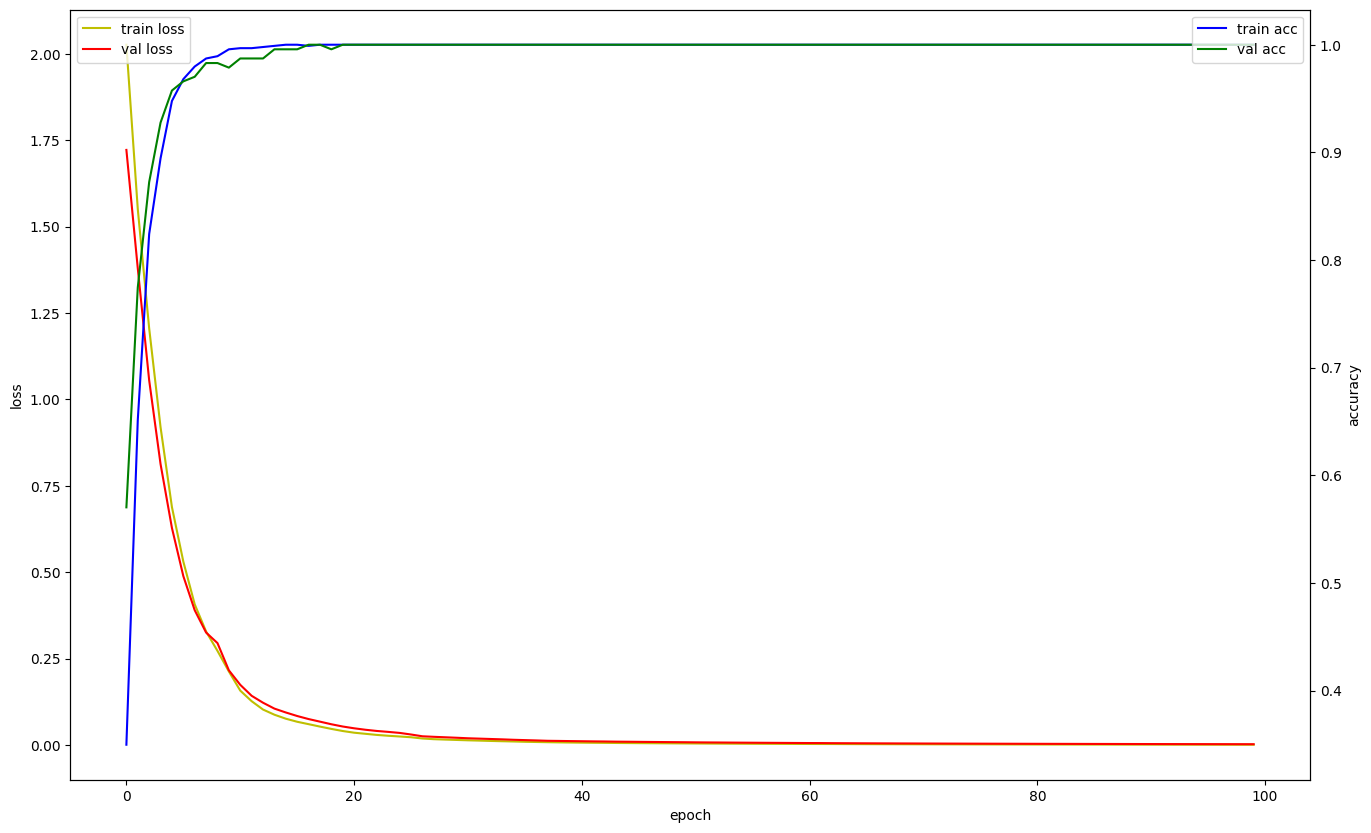

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()

In [ ]:
model.save(f'/content/drive/MyDrive/LAB/Sign_Language_Remaster/model/lstm_test20_e100.h5')

In [ ]:
from sklearn.metrics import accuracy_score
# model = load_model(f'/content/drive/MyDrive/Sign_Remaster/Sign_Language_Remaster/model/lstm_test8_e100.h5')
y_pred = model.predict(x_test)

y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)


15/15 [==============================] - 0s 2ms/step
Accuracy: 1.0
